In [1]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from scipy.stats import kendalltau, pearsonr
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import cross_validate, KFold

import os

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math as mt
from pylab import savefig
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers

from keras import backend as K

# model evaluation
from sklearn.model_selection import KFold, train_test_split 
from sklearn.metrics import r2_score, mean_squared_error

Using TensorFlow backend.


In [2]:
# LOAD TRAINING DATA FOR TRANSFER LEARNING
df_VALOX_total = pd.read_excel('./data/df_VALOX_total.xlsx',index_col=0).fillna(0)
data = df_VALOX_total
train_dataset = data.sample(frac=0.8,random_state=42)
test_dataset = data.drop(train_dataset.index)

train_stats = train_dataset.describe()
train_stats = train_stats.drop(['Part weight','Length','Angle', 'Height', 'Width'], axis=1)
train_stats = train_stats.transpose()
train_labels = train_dataset[['Part weight']]
test_labels = test_dataset[['Part weight']]

def norm(x):
    return (x - train_stats['mean']) / train_stats['std'] #zero-mean normalization, same with sklearn.preprocessing.StandardScaler
train_dataset = train_dataset.drop(['Part weight','Length','Angle','Height', 'Width'], axis=1)
test_dataset = test_dataset.drop(['Part weight','Length','Angle','Height', 'Width'], axis=1)
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

X_train = normed_train_data.fillna(0)
X_test = normed_test_data.fillna(0)
y_train = train_labels
y_test = test_labels

x = np.array(X_train, dtype=np.float)
y = np.array(y_train, dtype=np.float)
x = x.astype(float)
y = y.astype(float)

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
mol_num, feat_num = x.shape
print("Number of materials for training = %i, Number of features = %i\n" % (mol_num, feat_num))

Number of materials for training = 246, Number of features = 50



In [3]:
# create model
def MLP1(feat_num, loss):
    net = Sequential()
    net.add(Dense(50, input_dim=feat_num, kernel_initializer='normal', activation='relu'))
    net.add(Dense(25, kernel_initializer='normal', activation='relu'))
    net.add(Dense(10, kernel_initializer='normal', activation='relu'))
    net.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    net.compile(loss=loss, optimizer='adam')
    return net

### Without transfer

In [4]:
estimator = KerasRegressor(build_fn=MLP1,
                           feat_num=feat_num,
                           loss='mean_absolute_error',
                           epochs=300,
                           batch_size=int(x.shape[0] / 8),
                           verbose=0)
df_without_transfer = pd.DataFrame(columns=[
    'fit_time', 'score_time', 'test_r2', 'test_neg_mean_absolute_error'
])
df_without_transfer_result = pd.DataFrame(
    columns=['R2_mean', 'R2_std', 'neg_MAE_mean', 'neg_MAE_std'])

kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
for i in range(1, 11):
    scores = cross_validate(estimator,
                            x[0:int(x.shape[0] * 0.1 * i), :],
                            y[0:int(y.shape[0] * 0.1 * i), :],
                            scoring=('r2', 'neg_mean_absolute_error'),
                            cv=kfold,
                            return_train_score=False)

    df_scores = pd.DataFrame(scores)
    df_scores.index = pd.Series([
        '%d percent Fold1' % int(i * 10),
        '%d percent Fold2' % int(i * 10),
        '%d percent Fold3' % int(i * 10),
        '%d percent Fold4' % int(i * 10),
        '%d percent Fold5' % int(i * 10)
    ])

    df_results = pd.DataFrame([
        scores['test_r2'].mean(), scores['test_r2'].std(),
        scores['test_neg_mean_absolute_error'].mean(),
        scores['test_neg_mean_absolute_error'].std()
    ]).T
    df_results.index = pd.Series(['%d percent' % int(i * 10)])
    df_results.columns = pd.Series(
        ['R2_mean', 'R2_std', 'neg_MAE_mean', 'neg_MAE_std'])

    df_without_transfer = pd.concat([df_without_transfer, df_scores])
    df_without_transfer_result = pd.concat(
        [df_without_transfer_result, df_results], axis=0)
    print(df_scores)
    print(df_results)

                  fit_time  score_time   test_r2  test_neg_mean_absolute_error
10 percent Fold1  2.616578    0.086845 -3.528672                     -2.193476
10 percent Fold2  2.225513    0.091165 -3.353023                     -2.656223
10 percent Fold3  2.588188    0.095988 -4.110758                     -1.605000
10 percent Fold4  2.190681    0.062874 -8.051358                     -3.876898
10 percent Fold5  1.885265    0.062013 -0.332637                     -1.527309
            R2_mean    R2_std  neg_MAE_mean  neg_MAE_std
10 percent -3.87529  2.467318     -2.371781     0.857807
                  fit_time  score_time   test_r2  test_neg_mean_absolute_error
20 percent Fold1  2.435145    0.063759 -0.351798                     -1.374783
20 percent Fold2  2.605607    0.063717  0.832322                     -0.556405
20 percent Fold3  2.597592    0.062441  0.842025                     -0.554261
20 percent Fold4  2.466452    0.064521 -0.147760                     -1.297343
20 percent Fold5 

In [5]:
# load the dataset 
df_APEC_total=pd.read_excel('./data/df_APEC_total.xlsx',index_col=0)
df_PLEXIGLAS_total=pd.read_excel('./data/df_PLEXIGLAS_total.xlsx',index_col=0)
df_SABIC_total=pd.read_excel('./data/df_SABIC_total.xlsx',index_col=0)
df_ULTEM_total=pd.read_excel('./data/df_ULTEM_total.xlsx',index_col=0)
df_ULTRAMID_total=pd.read_excel('./data/df_ULTRAMID_total.xlsx',index_col=0)
df_VALOX_total=pd.read_excel('./data/df_VALOX_total.xlsx',index_col=0)
df = pd.concat([df_ULTEM_total, df_SABIC_total, df_ULTRAMID_total, df_PLEXIGLAS_total, df_APEC_total])
data = df.fillna(0)

train_dataset = data

train_stats = train_dataset.describe()
train_stats = train_stats.drop(['Part weight','Length','Angle', 'Height', 'Width'], axis=1)
train_stats = train_stats.transpose()
train_labels = train_dataset[['Part weight']]

def norm(x):
    return (x - train_stats['mean']) / train_stats['std'] #zero-mean normalization, same with sklearn.preprocessing.StandardScaler
train_dataset = train_dataset.drop(['Part weight','Length','Angle','Height', 'Width'], axis=1)
normed_train_data = norm(train_dataset)

### Fine Tuning

In [6]:
def transf_MLP(feat_num, idx, lhl_sizes, loss='mean_absolute_error'):
    global net  # net is a networks and cannot be pickled! Therefore it cannot be an input argument for cross_validate() to work!
    inp = Input(shape=(feat_num,))
    shared_layer = net.layers[0]
    shared_layer.trainable = True  # deactivate training in all re-used layers of MLP1
    out_tensor = shared_layer(inp)
    # idx = 1  # index of desired layer
    for i in range(1,idx+1):
        #print('Transfered layer %d' % i)
        shared_layer = net.layers[i]    # deactivate training in all re-used layers of MLP1
        shared_layer.trainable = True  # deactivate training in all re-used layers of MLP1
        out_tensor = shared_layer(out_tensor)
    # Here add all the new layers
    for l_size in lhl_sizes[idx:]:
        #print ('Rest layer size %d ' % l_size)
        out_tensor = Dense(l_size, kernel_initializer='normal', activation='relu')(out_tensor)
    # Close the network
    out_tensor = Dense(1, kernel_initializer='normal')(out_tensor)
    # Create the model
    transf_model = Model(inp, out_tensor)
    transf_model.compile(loss=loss, optimizer='adam')
    return transf_model

In [7]:
df_transfer_multisource = pd.DataFrame(columns=[
    'fit_time', 'score_time', 'test_r2', 'test_neg_mean_absolute_error'
])
df_transfer_multisource_result = pd.DataFrame(
    columns=['R2_mean', 'R2_std', 'neg_MAE_mean', 'neg_MAE_std'])
material_list = [
    df_ULTEM_total, df_SABIC_total, df_ULTRAMID_total, df_PLEXIGLAS_total,
    df_APEC_total
]
data_length = 0
for Num_source, material in enumerate(material_list):
    data_length = data_length + len(material)
    X_train = normed_train_data.iloc[:data_length]
    y_train = train_labels.iloc[:data_length]

    # Make the array shape to x, 1 for multiplication
    x_transf = np.array(X_train, dtype=np.float)
    y_transf = np.array(y_train, dtype=np.float)
    x_transf = x_transf.astype(float)
    y_transf = y_transf.astype(float)

    mol_num, feat_num = x_transf.shape
    print("Number for transfer training = %i, Number of features = %i\n" %
          (mol_num, feat_num))

    net = MLP1(feat_num=feat_num, loss='mean_absolute_error')
    net.fit(x_transf,
            y_transf,
            epochs=300,
            batch_size=int(x_transf.shape[0] / 8),
            verbose=0)

    estimator = KerasRegressor(build_fn=transf_MLP,
                               feat_num=feat_num,
                               idx=3,
                               lhl_sizes=(50, 25, 10),
                               loss='mean_absolute_error',
                               epochs=300,
                               batch_size=int(x.shape[0] / 8),
                               verbose=0)

    df_transfer_fine_tuning = pd.DataFrame(columns=[
        'fit_time', 'score_time', 'test_r2', 'test_neg_mean_absolute_error'
    ])
    df_transfer_fine_tuning_result = pd.DataFrame(
        columns=['R2_mean', 'R2_std', 'neg_MAE_mean', 'neg_MAE_std'])

    kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
    for i in range(1, 11):
        scores = cross_validate(estimator,
                                x[0:int(x.shape[0] * 0.1 * i), :],
                                y[0:int(y.shape[0] * 0.1 * i), :],
                                scoring=('r2', 'neg_mean_absolute_error'),
                                cv=kfold,
                                return_train_score=False)

        df_scores = pd.DataFrame(scores)
        df_scores.index = pd.Series([
            '%d percent Fold1' % int(i * 10),
            '%d percent Fold2' % int(i * 10),
            '%d percent Fold3' % int(i * 10),
            '%d percent Fold4' % int(i * 10),
            '%d percent Fold5' % int(i * 10)
        ])

        df_results = pd.DataFrame([
            scores['test_r2'].mean(), scores['test_r2'].std(),
            scores['test_neg_mean_absolute_error'].mean(),
            scores['test_neg_mean_absolute_error'].std()
        ]).T
        df_results.index = pd.Series(['%d percent' % int(i * 10)])
        df_results.columns = pd.Series(
            ['R2_mean', 'R2_std', 'neg_MAE_mean', 'neg_MAE_std'])

        df_transfer_fine_tuning = pd.concat(
            [df_transfer_fine_tuning, df_scores])
        df_transfer_fine_tuning_result = pd.concat(
            [df_transfer_fine_tuning_result, df_results], axis=0)
        print(df_scores)
        print(df_results)
    df_transfer_fine_tuning['Num_source'] = '%d' % (Num_source + 1)
    df_transfer_fine_tuning_result['Num_source'] = '%d' % (Num_source + 1)
    df_transfer_multisource = pd.concat(
        [df_transfer_multisource, df_transfer_fine_tuning], axis=0)
    df_transfer_multisource_result = pd.concat(
        [df_transfer_multisource_result, df_transfer_fine_tuning_result],
        axis=0)

Number for transfer training = 462, Number of features = 50

                  fit_time  score_time   test_r2  test_neg_mean_absolute_error
10 percent Fold1  2.177062    0.077122 -3.347441                     -2.245994
10 percent Fold2  2.072899    0.446689  0.186788                     -1.337201
10 percent Fold3  2.142581    0.079767 -0.459318                     -0.842446
10 percent Fold4  2.179370    0.076122  0.570011                     -1.109432
10 percent Fold5  2.229599    0.085118  0.664060                     -0.773136
            R2_mean   R2_std  neg_MAE_mean  neg_MAE_std
10 percent -0.47718  1.48853     -1.261642     0.531449
                  fit_time  score_time   test_r2  test_neg_mean_absolute_error
20 percent Fold1  2.994312    0.075882  0.495977                     -0.835312
20 percent Fold2  2.977750    0.076223  0.846232                     -0.530955
20 percent Fold3  3.073669    0.080173  0.856973                     -0.440951
20 percent Fold4  3.606927    0.08214

                  fit_time  score_time   test_r2  test_neg_mean_absolute_error
50 percent Fold1  6.245509    0.083520  0.924290                     -0.323900
50 percent Fold2  6.359353    0.083875  0.952419                     -0.321317
50 percent Fold3  7.641635    0.087288  0.935885                     -0.437797
50 percent Fold4  6.601961    0.084202  0.908534                     -0.448797
50 percent Fold5  6.578513    0.084405  0.952538                     -0.367889
             R2_mean    R2_std  neg_MAE_mean  neg_MAE_std
50 percent  0.934733  0.016891      -0.37994     0.054426
                  fit_time  score_time   test_r2  test_neg_mean_absolute_error
60 percent Fold1  6.613405    0.083611  0.928149                     -0.364457
60 percent Fold2  6.780317    0.086493  0.961249                     -0.283121
60 percent Fold3  7.085687    0.081582  0.973181                     -0.280701
60 percent Fold4  7.173502    0.084205  0.933857                     -0.302861
60 percent Fold

                   fit_time  score_time   test_r2  \
80 percent Fold1  20.007064    0.091184  0.955116   
80 percent Fold2  17.628089    0.125058  0.962323   
80 percent Fold3  18.806086    0.088535  0.958704   
80 percent Fold4  15.028789    0.090936  0.976476   
80 percent Fold5  16.007206    0.094125  0.942738   

                  test_neg_mean_absolute_error  
80 percent Fold1                     -0.361020  
80 percent Fold2                     -0.239987  
80 percent Fold3                     -0.365737  
80 percent Fold4                     -0.173222  
80 percent Fold5                     -0.329175  
             R2_mean    R2_std  neg_MAE_mean  neg_MAE_std
80 percent  0.959071  0.010919     -0.293828     0.075339
                   fit_time  score_time   test_r2  \
90 percent Fold1  20.453373    0.088032  0.977734   
90 percent Fold2  16.325516    0.092394  0.983809   
90 percent Fold3  17.157542    0.106769  0.956916   
90 percent Fold4  16.784566    0.090413  0.995812   
90 per

                    fit_time  score_time   test_r2  \
100 percent Fold1  30.597984    0.097305  0.976340   
100 percent Fold2  27.526119    0.101573  0.954926   
100 percent Fold3  28.896691    0.098530  0.981485   
100 percent Fold4  28.065633    0.097233  0.991405   
100 percent Fold5  28.897867    0.105702  0.968014   

                   test_neg_mean_absolute_error  
100 percent Fold1                     -0.194552  
100 percent Fold2                     -0.295768  
100 percent Fold3                     -0.189458  
100 percent Fold4                     -0.147665  
100 percent Fold5                     -0.243891  
              R2_mean    R2_std  neg_MAE_mean  neg_MAE_std
100 percent  0.974434  0.012354     -0.214267     0.050912
Number for transfer training = 4312, Number of features = 50

                  fit_time  score_time   test_r2  test_neg_mean_absolute_error
10 percent Fold1  2.596899    0.102031 -1.522791                     -1.850707
10 percent Fold2  3.374225    0.09463

In [8]:
df_transfer_multisource_result

,R2_mean,R2_std,neg_MAE_mean,neg_MAE_std,Num_source
10 percent,-0.477180,1.488530,-1.261642,0.531449,1
20 percent,0.765241,0.153973,-0.579226,0.156355,1
30 percent,0.867878,0.095762,-0.485674,0.085988,1
40 percent,0.910912,0.046117,-0.420252,0.118833,1
50 percent,0.888788,0.070029,-0.476795,0.166432,1
60 percent,0.934186,0.023399,-0.372747,0.103857,1
70 percent,0.942364,0.032215,-0.343629,0.076408,1
80 percent,0.960127,0.022921,-0.262585,0.073180,1
90 percent,0.964682,0.019386,-0.224633,0.065659,1
100 percent,0.956420,0.031535,-0.293829,0.143504,1


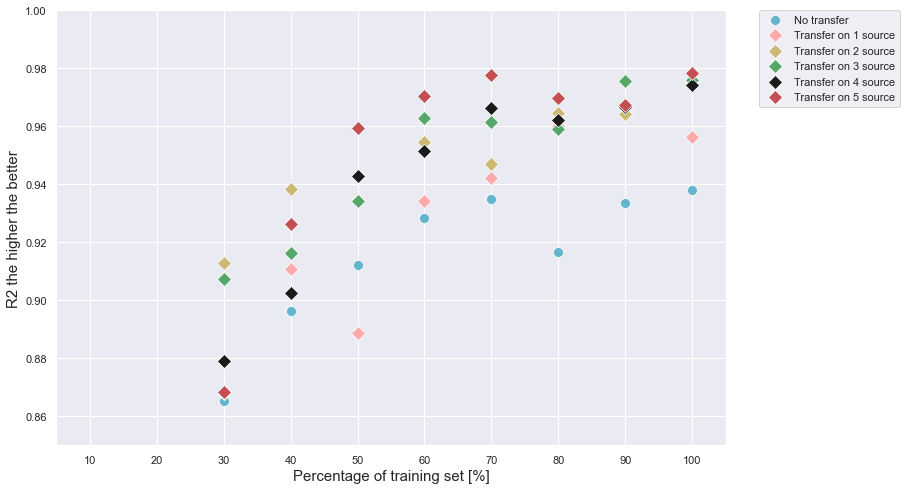

In [9]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
msize = 100
sns.set(rc={'figure.figsize':(12,8),'font.size': 16})
plt.xlim(5, 105)
plt.ylim(0.85, 1)
ax = sns.scatterplot(x=[10,22,30,40,50,60,70,80,90,100], y="R2_mean", data=df_without_transfer_result, label='No transfer', marker='o', color = 'c', s=msize)
ax = sns.scatterplot(x=[10,22,30,40,50,60,70,80,90,100], y="R2_mean", data=df_transfer_multisource_result[:10], 
                     label='Transfer on %d source' % int(df_transfer_multisource_result['Num_source'][0]),
                     marker = 'D', color = '#ffaaaa', s=msize)
ax = sns.scatterplot(x=[10,22,30,40,50,60,70,80,90,100], y="R2_mean", data=df_transfer_multisource_result[10:20], 
                     label='Transfer on %d source' % int(df_transfer_multisource_result['Num_source'][10]),
                     marker = 'D', color = 'y', s=msize)
ax = sns.scatterplot(x=[10,22,30,40,50,60,70,80,90,100], y="R2_mean", data=df_transfer_multisource_result[20:30], 
                     label='Transfer on %d source' % int(df_transfer_multisource_result['Num_source'][20]),
                     marker = 'D', color = 'g', s=msize)
ax = sns.scatterplot(x=[10,22,30,40,50,60,70,80,90,100], y="R2_mean", data=df_transfer_multisource_result[30:40], 
                     label='Transfer on %d source' % int(df_transfer_multisource_result['Num_source'][30]),
                     marker = 'D', color = 'k', s=msize)
ax = sns.scatterplot(x=[10,22,30,40,50,60,70,80,90,100], y="R2_mean", data=df_transfer_multisource_result[40:50], 
                     label='Transfer on %d source' % int(df_transfer_multisource_result['Num_source'][40]),
                     marker = 'D', color = 'r', s=msize)
#ax = sns.scatterplot(x=[10,22,30,40,50,60,70,80,90,100], y="R2_mean", data=df_transfer_fine_tuning_result, label='Transfer frozen', marker ='D', color = 'b', s=msize)
plt.xlabel('Percentage of training set [%]', fontsize=15)
plt.ylabel('R2 the higher the better', fontsize=15)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(np.arange(10, 110, 10))
plt.show()

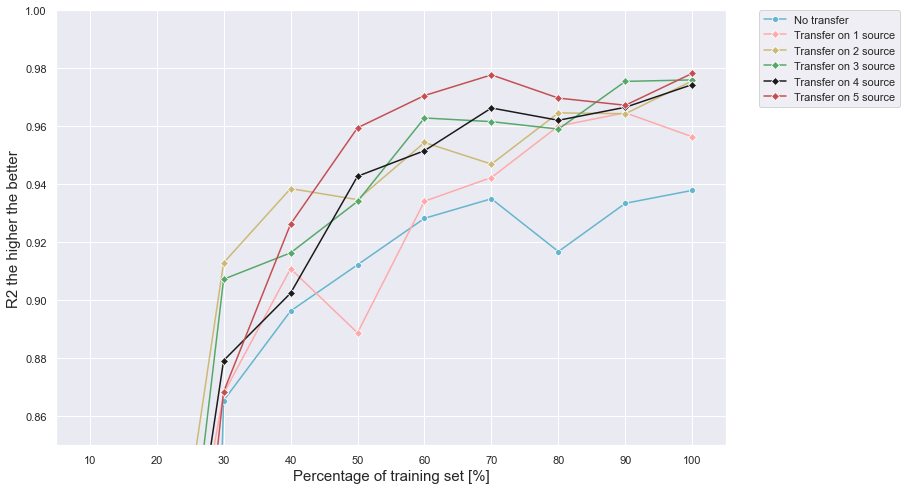

In [10]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
msize = 100
sns.set(rc={'figure.figsize': (12, 8), 'font.size': 16})
plt.xlim(5, 105)
plt.ylim(0.85, 1)
ax = sns.lineplot(x=[10, 22, 30, 40, 50, 60, 70, 80, 90, 100],
                  y="R2_mean",
                  data=df_without_transfer_result,
                  label='No transfer',
                  marker='o',
                  color='c')
ax = sns.lineplot(x=[10, 22, 30, 40, 50, 60, 70, 80, 90, 100],
                  y="R2_mean",
                  data=df_transfer_multisource_result[:10],
                  label='Transfer on %d source' %
                  int(df_transfer_multisource_result['Num_source'][0]),
                  marker='D',
                  color='#ffaaaa')
ax = sns.lineplot(x=[10, 22, 30, 40, 50, 60, 70, 80, 90, 100],
                  y="R2_mean",
                  data=df_transfer_multisource_result[10:20],
                  label='Transfer on %d source' %
                  int(df_transfer_multisource_result['Num_source'][10]),
                  marker='D',
                  color='y')
ax = sns.lineplot(x=[10, 22, 30, 40, 50, 60, 70, 80, 90, 100],
                  y="R2_mean",
                  data=df_transfer_multisource_result[20:30],
                  label='Transfer on %d source' %
                  int(df_transfer_multisource_result['Num_source'][20]),
                  marker='D',
                  color='g')
ax = sns.lineplot(x=[10, 22, 30, 40, 50, 60, 70, 80, 90, 100],
                  y="R2_mean",
                  data=df_transfer_multisource_result[30:40],
                  label='Transfer on %d source' %
                  int(df_transfer_multisource_result['Num_source'][30]),
                  marker='D',
                  color='k')
ax = sns.lineplot(x=[10, 22, 30, 40, 50, 60, 70, 80, 90, 100],
                  y="R2_mean",
                  data=df_transfer_multisource_result[40:50],
                  label='Transfer on %d source' %
                  int(df_transfer_multisource_result['Num_source'][40]),
                  marker='D',
                  color='r')
plt.xlabel('Percentage of training set [%]', fontsize=15)
plt.ylabel('R2 the higher the better', fontsize=15)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(np.arange(10, 110, 10))
plt.show()

### Transfer frozen

In [11]:
def transf_MLP(feat_num, idx, lhl_sizes, loss='mean_absolute_error'):
    global net  # net is a networks and cannot be pickled! Therefore it cannot be an input argument for cross_validate() to work!
    inp = Input(shape=(feat_num,))
    shared_layer = net.layers[0]
    shared_layer.trainable = False  # deactivate training in all re-used layers of MLP1
    out_tensor = shared_layer(inp)
    # idx = 1  # index of desired layer
    for i in range(1,idx+1):
        #print('Transfered layer %d' % i)
        shared_layer = net.layers[i]    # deactivate training in all re-used layers of MLP1
        shared_layer.trainable = False  # deactivate training in all re-used layers of MLP1
        out_tensor = shared_layer(out_tensor)
    # Here add all the new layers
    for l_size in lhl_sizes[idx:]:
        #print ('Rest layer size %d ' % l_size)
        out_tensor = Dense(l_size, kernel_initializer='normal', activation='relu')(out_tensor)
    # Close the network
    out_tensor = Dense(1, kernel_initializer='normal')(out_tensor)
    # Create the model
    transf_model = Model(inp, out_tensor)
    transf_model.compile(loss=loss, optimizer='adam')
    return transf_model

In [12]:
df_transfer_multisource= pd.DataFrame(columns=['fit_time', 'score_time', 'test_r2','test_neg_mean_absolute_error'])
df_transfer_multisource_result = pd.DataFrame(columns=['R2_mean', 'R2_std',
                                                   'neg_MAE_mean','neg_MAE_std'])
material_list = [df_SABIC_total, df_VALOX_total, df_ULTEM_total, df_ULTRAMID_total, df_PLEXIGLAS_total]
data_length = 0
for Num_source, material in enumerate(material_list):
    data_length = data_length + len(material)
    X_train = normed_train_data.iloc[:data_length]
    y_train = train_labels.iloc[:data_length]
    
    # Make the array shape to x, 1 for multiplication
    x_transf = np.array(X_train, dtype=np.float)
    y_transf = np.array(y_train, dtype=np.float)
    x_transf = x_transf.astype(float)
    y_transf = y_transf.astype(float)

    mol_num, feat_num = x_transf.shape
    print("Number for transfer training = %i, Number of features = %i\n" % (mol_num, feat_num))

    
    net = MLP1(feat_num=feat_num, 
               loss='mean_absolute_error')
    net.fit(x_transf, 
            y_transf,
            epochs=300, 
            batch_size=int(x_transf.shape[0]/8), 
            verbose=0)

    estimator = KerasRegressor(build_fn=transf_MLP,
                               feat_num=feat_num,
                               idx=0,
                               lhl_sizes=(50, 25, 10),
                               loss='mean_absolute_error',
                               epochs=300,
                               batch_size=int(x.shape[0]/8),
                               verbose=0)

    df_transfer_frozen= pd.DataFrame(columns=['fit_time', 'score_time', 'test_r2','test_neg_mean_absolute_error'])
    df_transfer_frozen_result = pd.DataFrame(columns=['R2_mean', 'R2_std',
                                                       'neg_MAE_mean','neg_MAE_std'])

    kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
    for i in range(1,11):
        scores = cross_validate(estimator, x[0:int(x.shape[0]*0.1*i),:], y[0:int(y.shape[0]*0.1*i),:], scoring=('r2', 'neg_mean_absolute_error'), cv=kfold, return_train_score=False)

        df_scores = pd.DataFrame(scores)
        df_scores.index =pd.Series(['%d percent Fold1'% int(i*10), '%d percent Fold2'% int(i*10), 
                                          '%d percent Fold3'% int(i*10), '%d percent Fold4'% int(i*10),
                                          '%d percent Fold5'% int(i*10)])

        df_results = pd.DataFrame([scores['test_r2'].mean(), scores['test_r2'].std(), 
                                scores['test_neg_mean_absolute_error'].mean(), 
                                scores['test_neg_mean_absolute_error'].std()]).T
        df_results.index =pd.Series(['%d percent'% int(i*10)])
        df_results.columns =pd.Series(['R2_mean', 'R2_std','neg_MAE_mean','neg_MAE_std'])

        df_transfer_frozen = pd.concat([df_transfer_frozen, df_scores])
        df_transfer_frozen_result = pd.concat([df_transfer_frozen_result, df_results], axis=0)
        print(df_scores)
        print(df_results)
    df_transfer_frozen['Num_source']='%d'% (Num_source+1)
    df_transfer_frozen_result['Num_source']='%d'% (Num_source+1)
    df_transfer_multisource = pd.concat([df_transfer_multisource, df_transfer_frozen], axis=0)
    df_transfer_multisource_result = pd.concat([df_transfer_multisource_result, df_transfer_frozen_result], axis=0)
    

Number for transfer training = 1309, Number of features = 50

                   fit_time  score_time     test_r2  \
10 percent Fold1   2.471448    0.103140 -355.744185   
10 percent Fold2   2.256123    0.107265  -66.585039   
10 percent Fold3   2.170761    0.112044 -749.710016   
10 percent Fold4   2.144641    0.104581   -1.813252   
10 percent Fold5  11.139320    0.124080 -185.014241   

                  test_neg_mean_absolute_error  
10 percent Fold1                    -16.726342  
10 percent Fold2                     -7.964539  
10 percent Fold3                    -16.141210  
10 percent Fold4                     -2.659465  
10 percent Fold5                    -10.860301  
               R2_mean      R2_std  neg_MAE_mean  neg_MAE_std
10 percent -271.773347  267.575185    -10.870371     5.252372
                  fit_time  score_time    test_r2  \
20 percent Fold1  2.944022    0.107649  -5.128029   
20 percent Fold2  2.854643    0.109832 -78.662278   
20 percent Fold3  2.905956    

                  fit_time  score_time   test_r2  test_neg_mean_absolute_error
40 percent Fold1  3.649443    0.117978 -0.247595                     -1.814772
40 percent Fold2  3.628302    0.131082 -1.944818                     -2.189637
40 percent Fold3  3.703916    0.124294 -0.655732                     -1.600455
40 percent Fold4  3.539105    0.108165 -1.436137                     -2.248212
40 percent Fold5  3.686027    0.135145 -0.279215                     -1.637426
             R2_mean    R2_std  neg_MAE_mean  neg_MAE_std
40 percent -0.912699  0.670665       -1.8981     0.272419
                  fit_time  score_time     test_r2  \
50 percent Fold1  4.210555    0.113790   -0.884778   
50 percent Fold2  4.331620    0.119488   -1.241607   
50 percent Fold3  4.199890    0.118048 -989.247638   
50 percent Fold4  4.172611    0.123011   -0.403121   
50 percent Fold5  4.361963    0.116169   -0.212075   

                  test_neg_mean_absolute_error  
50 percent Fold1                    

                  fit_time  score_time   test_r2  test_neg_mean_absolute_error
80 percent Fold1  5.668600    0.123434  0.926857                     -0.509971
80 percent Fold2  5.747736    0.124542  0.832717                     -0.642735
80 percent Fold3  6.392828    0.131868  0.809620                     -0.760754
80 percent Fold4  6.249174    0.131057  0.766687                     -0.833900
80 percent Fold5  5.593830    0.124119  0.707488                     -0.888744
             R2_mean    R2_std  neg_MAE_mean  neg_MAE_std
80 percent  0.808674  0.072867     -0.727221      0.13633
                  fit_time  score_time   test_r2  test_neg_mean_absolute_error
90 percent Fold1  5.560710    0.118094  0.880840                     -0.627473
90 percent Fold2  5.746869    0.129265  0.822013                     -0.741330
90 percent Fold3  5.583790    0.126232  0.866474                     -0.690390
90 percent Fold4  5.561431    0.125333  0.867388                     -0.605754
90 percent Fold

                  fit_time  score_time    test_r2  \
10 percent Fold1  2.296914    0.128057 -62.933479   
10 percent Fold2  2.308387    0.124881  -4.496730   
10 percent Fold3  2.335628    0.131919 -68.892578   
10 percent Fold4  2.295492    0.127612   0.148667   
10 percent Fold5  2.279486    0.134500  -5.183416   

                  test_neg_mean_absolute_error  
10 percent Fold1                     -7.464166  
10 percent Fold2                     -2.761048  
10 percent Fold3                     -5.208037  
10 percent Fold4                     -1.454467  
10 percent Fold5                     -3.231658  
              R2_mean     R2_std  neg_MAE_mean  neg_MAE_std
10 percent -28.271507  30.846491     -4.023875     2.100573
                  fit_time  score_time   test_r2  test_neg_mean_absolute_error
20 percent Fold1  2.982948    0.141506 -0.569906                     -1.403198
20 percent Fold2  3.048141    0.142365  0.215720                     -1.251159
20 percent Fold3  3.097932    

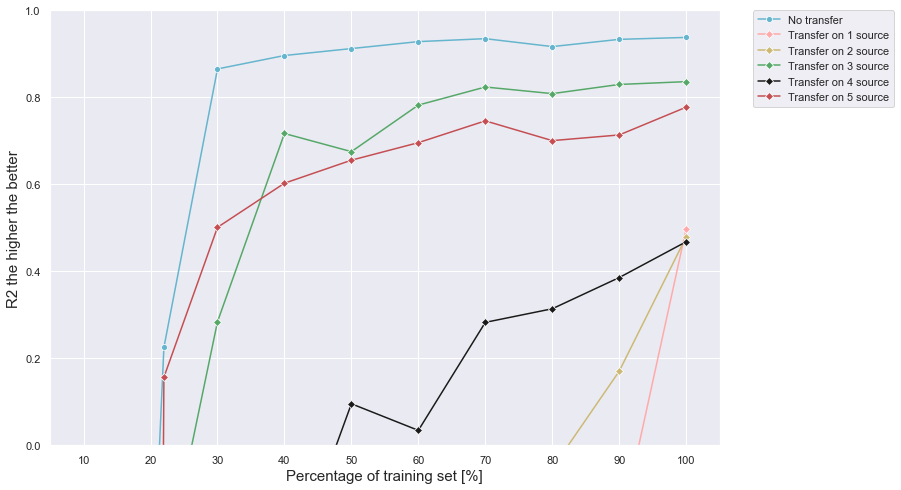

In [13]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
msize = 100
sns.set(rc={'figure.figsize':(12,8),'font.size': 16})
plt.xlim(5, 105)
plt.ylim(0, 1)
ax = sns.lineplot(x=[10,22,30,40,50,60,70,80,90,100], y="R2_mean", data=df_without_transfer_result, 
                  label='No transfer', marker='o', color = 'c')
ax = sns.lineplot(x=[10,22,30,40,50,60,70,80,90,100], y="R2_mean", data=df_transfer_multisource_result[:10], 
                     label='Transfer on %d source' % int(df_transfer_multisource_result['Num_source'][0]),
                     marker = 'D', color = '#ffaaaa')
ax = sns.lineplot(x=[10,22,30,40,50,60,70,80,90,100], y="R2_mean", data=df_transfer_multisource_result[10:20], 
                     label='Transfer on %d source' % int(df_transfer_multisource_result['Num_source'][10]),
                     marker = 'D', color = 'y')
ax = sns.lineplot(x=[10,22,30,40,50,60,70,80,90,100], y="R2_mean", data=df_transfer_multisource_result[20:30], 
                     label='Transfer on %d source' % int(df_transfer_multisource_result['Num_source'][20]),
                     marker = 'D', color = 'g')
ax = sns.lineplot(x=[10,22,30,40,50,60,70,80,90,100], y="R2_mean", data=df_transfer_multisource_result[30:40], 
                     label='Transfer on %d source' % int(df_transfer_multisource_result['Num_source'][30]),
                     marker = 'D', color = 'k')
ax = sns.lineplot(x=[10,22,30,40,50,60,70,80,90,100], y="R2_mean", data=df_transfer_multisource_result[40:50], 
                     label='Transfer on %d source' % int(df_transfer_multisource_result['Num_source'][40]),
                     marker = 'D', color = 'r')
plt.xlabel('Percentage of training set [%]', fontsize=15)
plt.ylabel('R2 the higher the better', fontsize=15)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(np.arange(10, 110, 10))
plt.show()